# Simulation of data

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.formula.api as smf

from datetime import date, timedelta, datetime
import random

colors = plt.cycler(color=["#557A95",   "#957055", "#559570"]) 
sns.set_context('paper', font_scale=1.4)
plt.rcParams['figure.figsize'] = [9,6]
plt.rcParams['savefig.dpi'] = 300
plt.rc("legend", frameon=False)
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['axes.prop_cycle'] = colors
mycolors = colors.by_key()["color"]

## Make fake data

In [3]:
def rnd_dates(start_dts:datetime.date, 
              end_dts:datetime.date, 
              size=100):
    
    random_date = [start_dts + timedelta(days=random.randrange((end_dts - start_dts).days)) 
                   for _ in range(n)]
    return random_date

In [4]:
np.random.seed(102323)
n = 500 

In [5]:
# Simulate customers which churned
np.random.seed(102323)
age = np.random.choice(range(18,60), size=n)
payment = np.random.choice(["paypal","credit card","manual transfer"], p=[0.4,0.3,0.3], size=n)
area = np.random.choice([1,2,3],p=[0.1,0.3,0.6],size=n)
dates = rnd_dates(date(2019,1,1),date(2019,7,31), size=n)
X_churned = np.c_[age, payment, area, dates]
a = 0.845
y_churned = np.random.choice([0,1], p=[1-a,a], size=n)

In [6]:
# Simulate customers which did not churn
np.random.seed(102323)
age = np.random.choice(range(30,81),size=n)
payment = np.random.choice(["paypal","credit card","manual transfer"], p=[0.1,0.2,0.7], size=n)
area = np.random.choice([1,2,3],p=[0.6,0.3,0.1],size=n)
dates = rnd_dates(date(2019,3,1),date(2019,12,31), size=n)
X_notchurned = np.c_[age, payment, area, dates]
a = 0.173
y_notchurned = np.random.choice([0,1], p=[1-a,a], size=n)

In [7]:
# Data not informative for modell
np.random.seed(102323)
gender = np.random.choice(["male","female"], size=n*2)
tenor = np.round(stats.lognorm(1.6).rvs(n*2),0)
bill = np.round(stats.lognorm(1.1).rvs(n*2) * 25,2)

In [8]:
X = np.vstack((X_churned, X_notchurned))
y = np.hstack((y_churned, y_notchurned))#
X.shape, y.shape

((1000, 4), (1000,))

In [9]:
df = pd.DataFrame(np.c_[y,X], columns=["churn","age", "type_payment","region", "contract_date"])
df["gender"] = gender 
df["tenor"] = tenor
df["bill"] = bill

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
int_cols = ["churn","age", "region"]
df[int_cols] = df[int_cols].astype(int)
df[["tenor","bill"]] = df[["tenor","bill"]].astype(float)
df[["contract_date"]] = df[["contract_date"]].apply(pd.to_datetime)

In [12]:
df.head()

,churn,age,type_payment,region,contract_date,gender,tenor,bill
0,0,47,paypal,1,2019-10-30,male,0.0,21.92
1,1,32,manual transfer,2,2019-07-16,female,0.0,31.91
2,1,42,manual transfer,2,2019-06-19,male,0.0,21.36
3,0,38,manual transfer,1,2019-07-14,male,2.0,49.83
4,1,43,credit card,3,2019-03-02,male,1.0,55.29


In [13]:
#df.to_csv("Churn.csv",index=False)

## Build simple models for testing

In [17]:
link = "https://raw.githubusercontent.com/fredzett/Notebooks/master/Churn.csv"
df = pd.read_csv(link)
df["contract_date"] = df["contract_date"].apply(pd.to_datetime)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   churn          1000 non-null   int64         
 1   age            1000 non-null   int64         
 2   type_payment   1000 non-null   object        
 3   region         1000 non-null   int64         
 4   contract_date  1000 non-null   datetime64[ns]
 5   gender         1000 non-null   object        
 6   tenor          1000 non-null   float64       
 7   bill           1000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 62.6+ KB


In [19]:
df["month"] = df["contract_date"].dt.month

In [44]:
full = "churn ~ age + type_payment + C(region) + gender + tenor + bill + month"
part = "churn ~ age"
model = smf.logit(full,data=df).fit()

Optimization terminated successfully.
         Current function value: 0.520348
         Iterations 6


In [45]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      990
Method:                           MLE   Df Model:                            9
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                  0.2493
Time:                        20:55:06   Log-Likelihood:                -520.35
converged:                       True   LL-Null:                       -693.13
Covariance Type:            nonrobust   LLR p-value:                 5.450e-69
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.5602      0.360      4.332      0.000       0.854       2.266
type_payment[T.manual transfer]    -0.3739      0.186     -2.013      0.044      -0.738      -0.010
type_payment[T.paypal]              0.5428      0.224      2.428      0.015       0.105       0.981
C(region)[T.2]                      0.9053      0.185      4.893      0.000       0.543       1.268
C(region)[T.3]                      1.6682      0.195      8.556      0.000       1.286       2.050
gender[T.male]                      0.2684      0.153      1.752      0.080      -0.032       0.569
age                                -0.0307      0.005     -5.816      0.000      -0.041      -0.020
tenor                              -0.0073      0.008     -0.938      0.348      -0.022       0.008
bill                                0.0008      0.001      0.620      0.535      -0.002       0.003
month                              -0.1817      0.029     -6.348      0.000      -0.238      -0.126
===================================================================================================
"""

In [46]:
model.pred_table()

array([[384., 113.],
       [102., 401.]])

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

In [48]:
yhat = 1/(1+np.exp(-model.fittedvalues))
yhat = np.where(yhat > 0.5,1,0)

In [49]:
df["churn_predicted"] = yhat

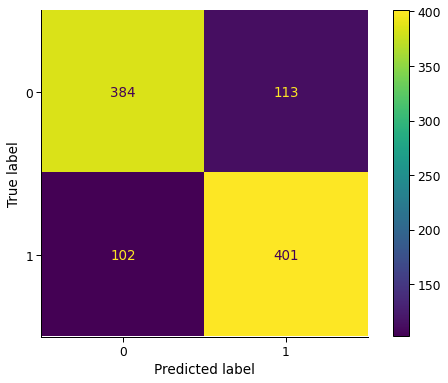

In [50]:
cm = confusion_matrix(df["churn"], df["churn_predicted"])
ConfusionMatrixDisplay(cm).plot()

(0.0, 1.0)

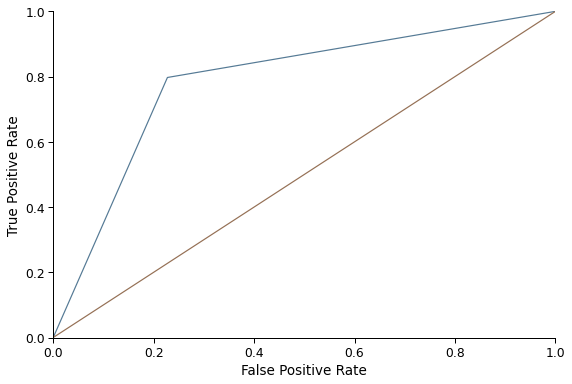

In [51]:
fpr, tpr, thresholds = roc_curve(df["churn"],df["churn_predicted"])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot(thresholds, thresholds)
plt.ylim([0,1])
plt.xlim([0,1])

In [40]:
fpr

array([0.        , 0.40241449, 1.        ])

In [1130]:
all_accs = []
cs = np.linspace(0.30,0.55,num=1000)
for c in cs:
    yhat = np.where(1/(1+np.exp(-model.fittedvalues)) >c,1,0)
    acc = accuracy_score(yhat,df["churn"])
    all_accs.append(acc)

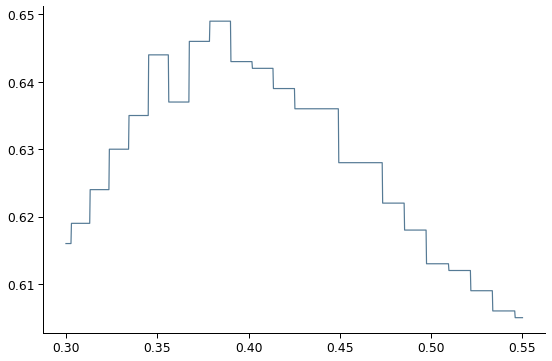

In [1131]:
plt.plot(cs,all_accs)

In [1132]:
df.churn

0      0
1      1
2      1
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    1
Name: churn, Length: 1000, dtype: int64

In [1133]:
churn = df["churn"] + stats.norm(0,1).rvs(n*2) * 0.05

Text(0.5, 1.0, 'Churn vs. age\n(spreaded to show categories)')

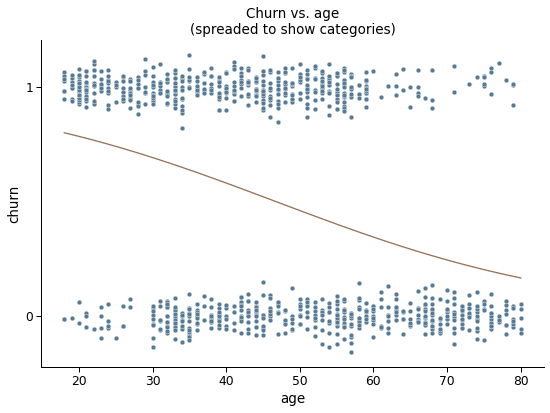

In [1134]:
col = "age"
sns.scatterplot(x=df[col],y=churn,estimator=False)
probs = 1/(1+np.exp(-model.fittedvalues))
sns.lineplot(x=df[col],y=probs, color=mycolors[1])
plt.yticks([0,1])
plt.title("Churn vs. age\n(spreaded to show categories)")

<AxesSubplot:xlabel='age', ylabel='churn'>

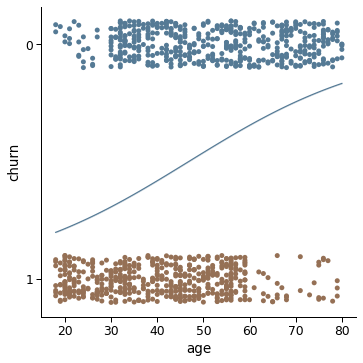

In [1137]:
sns.catplot(x="age",y="churn", data=df,orient="h", )
sns.lineplot(y=probs, x=df["age"])

In [1138]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score

In [1139]:
df = df[["churn","age","region","tenor","bill","month"]]

In [1140]:
clf = DecisionTreeClassifier()
X, y = df.drop(labels="churn", axis=1), df["churn"]

In [1141]:
clf.fit(X,y)

DecisionTreeClassifier()

In [1142]:
yhat = clf.predict(X)

In [1143]:
confusion_matrix(df["churn"],yhat)

array([[497,   0],
       [  0, 503]])